In [1]:
import xarray as xr
import numpy as np
from glob import glob
from xgcm.grid import Grid

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RAC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
hFacW =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacW.data', dtype='>f4')
hFacS =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacS.data', dtype='>f4')

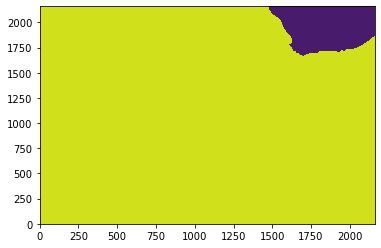

In [3]:
import matplotlib.pyplot as plt
plt.contourf(hFacW.reshape(90,2160,2160)[0,:,:])

In [4]:
# Load Eulerian data
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')

uvel_merged = uvel_merged.isel(time=slice(1,110)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(1,110)).isel(k=0)

uvel_merged = uvel_merged.drop_vars('time')
vvel_merged = vvel_merged.drop_vars('time')

In [5]:
def lanczos(x, a):
    return np.sinc(x/a)
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [6]:
nofiles=49
u_eul_filtered = uvel_merged.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
v_eul_filtered = vvel_merged.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_eul_filtered = u_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [7]:
eul_filtered_vels = u_eul_filtered.to_dataset(name='u')
eul_filtered_vels['v'] = v_eul_filtered
eul_filtered_vels = eul_filtered_vels.assign_coords({"hFacC":(["j","i"],hFacC.reshape(90,2160,2160)[0,:,:])})
eul_filtered_vels = eul_filtered_vels.assign_coords({"hFacW":(["j","i_g"],hFacW.reshape(90,2160,2160)[0,:,:])})
eul_filtered_vels = eul_filtered_vels.assign_coords({"hFacS":(["j_g","i"],hFacS.reshape(90,2160,2160)[0,:,:])})
eul_filtered_vels = eul_filtered_vels.assign_coords({"dxG":(["j_g","i"],DXG.reshape(2160,2160))})
eul_filtered_vels = eul_filtered_vels.assign_coords({"dyG":(["j","i_g"],DYG.reshape(2160,2160))})
eul_filtered_vels = eul_filtered_vels.assign_coords({"raC":(["j","i"],RAC.reshape(2160,2160))})
eul_filtered_vels = eul_filtered_vels.assign_coords(drF = DRF[0])
eul_filtered_vels.time.attrs['units']='time in seconds'
eul_filtered_vels.u.attrs['units']='m/s'
eul_filtered_vels.v.attrs['units']='m/s'
eul_filtered_vels.chunk({'i':180,'j_g':180,'j':180,'i_g':180}).to_zarr('/swot/SUM03/spencer/agulhas_vels/eul_filtered_vels.zarr')

In [9]:
grid = Grid(eul_filtered_vels,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})

In [10]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,49):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where(ds.u!=-999)
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=3)
        v_piece = windowed_v.sel(time=0).isel(z0=3)
        u_piece2 = ds.u.sel(time=0).isel(z0=3)
        v_piece2 = ds.v.sel(time=0).isel(z0=3)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

In [11]:
unfiltered_vels = u_unfiltered.to_dataset(name='u')
unfiltered_vels['v'] = v_unfiltered
unfiltered_vels.time.attrs['units']='time in seconds'
unfiltered_vels.u.attrs['units']='m/s'
unfiltered_vels.v.attrs['units']='m/s'
unfiltered_vels.y0.attrs['long_name']='latitude'
unfiltered_vels.x0.attrs['units']='longitude'
unfiltered_vels = unfiltered_vels.rename_dims({"x0":"i"})
unfiltered_vels = unfiltered_vels.rename_dims({"y0":"j"})

In [12]:
unf_u_points = grid.interp(unfiltered_vels.u,'X')
unf_v_points = grid.interp(unfiltered_vels.v,'Y')

In [13]:
unfiltered_vels2 = unf_u_points.to_dataset(name='u')
unfiltered_vels2['v'] = unf_v_points
unfiltered_vels2.time.attrs['units']='time in seconds'
unfiltered_vels2.u.attrs['units']='m/s'
unfiltered_vels2.v.attrs['units']='m/s'
unfiltered_vels2.chunk({'i':180,'j_g':180,'j':180,'i_g':180}).to_zarr('/swot/SUM03/spencer/agulhas_vels/unfiltered_vels.zarr')

In [14]:
filtered_vels = u_filtered.to_dataset(name='u')
filtered_vels['v'] = v_filtered
filtered_vels.time.attrs['units']='time in seconds'
filtered_vels.u.attrs['units']='m/s'
filtered_vels.v.attrs['units']='m/s'
filtered_vels.y0.attrs['long_name']='latitude'
filtered_vels.x0.attrs['units']='longitude'
filtered_vels = filtered_vels.rename_dims({"x0":"i"})
filtered_vels = filtered_vels.rename_dims({"y0":"j"})


In [15]:
filt_u_points = grid.interp(filtered_vels.u,'X')
filt_v_points = grid.interp(filtered_vels.v,'Y')

In [16]:
filtered_vels2 = filt_u_points.to_dataset(name='u')
filtered_vels2['v'] = filt_v_points
filtered_vels2.time.attrs['units']='time in seconds'
filtered_vels2.u.attrs['units']='m/s'
filtered_vels2.v.attrs['units']='m/s'
filtered_vels2.chunk({'i':180,'j_g':180,'j':180,'i_g':180}).to_zarr('/swot/SUM03/spencer/agulhas_vels/filtered_vels.zarr')

In [8]:
filt_u_points

NameError: name 'filt_u_points' is not defined